# Training Metrics Analysis
This notebook loads `runs/all_training_metrics.csv` (the master log you created while training) and plots trends for:
- reward
- total_loss
- policy_loss
- value_loss
- entropy

## How to use
1. Set `CSV_PATH` if your file lives elsewhere.
2. Run the **Setup** cell.
3. Use the helper functions to plot per-run/per-label curves.
4. Optionally set `rolling` window (e.g., 50) to smooth noisy curves.


In [3]:
# === Setup ===
stamp = "20250928_032108"
CSV_PATH = f"runs/all_training_metrics_{stamp}.csv"  # change this if needed

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from drl_framework import params

# Load
df = pd.read_csv(CSV_PATH)

# Basic sanity check / peek
print("Rows:", len(df))
print("Columns:", list(df.columns))
print("\nUnique run_id:", df['run_id'].nunique())
print("Unique labels:", sorted(df['label'].unique()))
print("\nSample rows:")
display(df.head())

# Sort for consistency
df = df.sort_values(['run_id','label','episode']).reset_index(drop=True)


Rows: 6000
Columns: ['run_id', 'label', 'episode', 'reward', 'policy_loss', 'value_loss', 'entropy', 'total_loss']

Unique run_id: 2
Unique labels: ['Global', 'Individual_0', 'Individual_1', 'Individual_2', 'Individual_3', 'Individual_4']

Sample rows:


,run_id,label,episode,reward,policy_loss,value_loss,entropy,total_loss
0,a3c_20250928_032108,Global,1,1749.9,0.002440,11788.397595,1.074061,5894.190363
1,a3c_20250928_032108,Global,2,1619.1,-0.007622,10067.174081,1.083083,5033.568242
2,a3c_20250928_032108,Global,3,1998.3,-0.000536,44868.888208,1.017026,22434.432800
3,a3c_20250928_032108,Global,4,1922.0,-0.037779,9226.953259,0.994549,4613.428961
4,a3c_20250928_032108,Global,5,1997.5,0.039576,28146.056226,0.959267,14073.057996


In [4]:
# === Helpers ===
def get_df(run_id=None, label=None):
    sub = df.copy()
    if run_id is not None:
        sub = sub[sub['run_id'] == run_id]
    if label is not None:
        sub = sub[sub['label'] == label]
    return sub.sort_values('episode')

def plot_metric(run_id=None, label=None, metric='reward', rolling=None, save=False, outdir='plots'):
    data = get_df(run_id, label)
    if data.empty:
        print("No data for the given filter.")
        return
    y = data[metric]
    if rolling is not None and rolling > 1:
        y = y.rolling(rolling, min_periods=1).mean()

    plt.figure()
    plt.plot(data['episode'], y)
    plt.xlabel('Episode')
    plt.ylabel(metric.replace('_',' ').title())
    title = f"{metric.replace('_',' ').title()} vs Episode"
    if label: title += f" - {label}"
    if run_id: title += f" - {run_id}"
    plt.title(title)
    plt.tight_layout()
    if save:
        Path(outdir).mkdir(parents=True, exist_ok=True)
        fname = f"{metric}_{(label or 'All')}_{(run_id or 'All')}.png".replace('/','-')
        plt.savefig(Path(outdir)/fname, dpi=180)
    plt.show()

def plot_compare_labels(run_id, metric='reward', rolling=None):
    data = df[df['run_id'] == run_id]
    if data.empty:
        print("No data for this run_id.")
        return
    labels = sorted(data['label'].unique())
    plt.figure()
    for lb in labels:
        sub = data[data['label'] == lb].sort_values('episode')
        series = sub[metric]
        if rolling is not None and rolling > 1:
            series = series.rolling(rolling, min_periods=1).mean()
        plt.plot(sub['episode'], series, label=lb)
    plt.xlabel('Episode')
    plt.ylabel(metric.replace('_',' ').title())
    plt.title(f"{metric.replace('_',' ').title()} vs Episode - {run_id}")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Quick start
- The next cell picks the most recent `run_id` by default and label `"Global"`.
- Adjust `RUN_ID` and `LABEL` as needed.


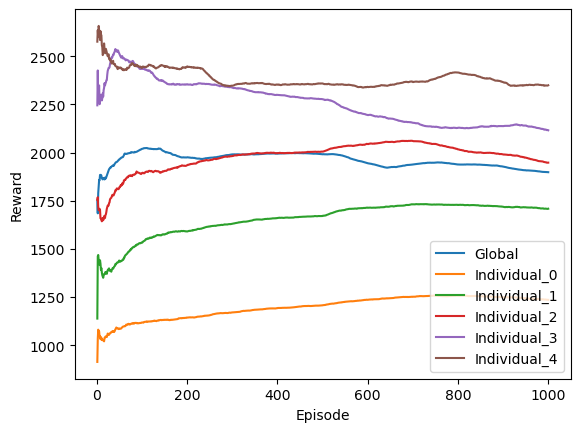

In [5]:
plt.figure()
rolling = 500

for label in sorted(df['label'].unique()):
    if label == 'Global':
        plt.plot(df[df['label']==label]['episode'], df[df['label']==label]['reward'].rolling(rolling, min_periods=1).mean(), label=label)
    else:
        plt.plot(df[df['label']==label]['episode'], df[df['label']==label]['reward'].rolling(rolling, min_periods=1).mean(), label=label)

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

# Evaluation log analysis

In [6]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt

worker_ids = range(5)
env_ids = range(5)

# Make a blank figure
plt.figure(figsize=(12, 8))

# Read A3C CSV files
for env in env_ids:
    df = pd.read_csv(f"a3c_global_env{env}_actions.csv")
    # Make a list that contains the sum of rewards for each episode
    episode_rewards = df.groupby("episode")["reward"].sum().tolist()
    print(f"Env {env}, A3C - Episodes: {len(episode_rewards)}, Avg. Reward: {sum(episode_rewards)/len(episode_rewards)}")

    for worker_id in worker_ids:
        df = pd.read_csv(f"individual_w{worker_id}_env{env}_actions.csv")
        # Make a list that contains the sum of rewards for each episode
        episode_rewards = df.groupby("episode")["reward"].sum().tolist()
        print(f"Env {env}, Worker {worker_id} - Episodes: {len(episode_rewards)}, Avg. Reward: {sum(episode_rewards)/len(episode_rewards)}")

# for worker_id, env_id in itertools.product(worker_ids, env_ids):
#     df = pd.read_csv(f"individual_w{worker_id}_env{env_id}_actions.csv")
#     # Make a list that contains the sum of rewards for each episode
#     episode_rewards = df.groupby("episode")["reward"].sum().tolist()
#     print(f"Worker {worker_id}, Env {env_id} - Episodes: {len(episode_rewards)}, Avg. Reward: {sum(episode_rewards)/len(episode_rewards)}")


Env 0, A3C - Episodes: 10, Avg. Reward: 326.2
Env 0, Worker 0 - Episodes: 10, Avg. Reward: 323.55
Env 0, Worker 1 - Episodes: 10, Avg. Reward: 325.1
Env 0, Worker 2 - Episodes: 10, Avg. Reward: 326.55
Env 0, Worker 3 - Episodes: 10, Avg. Reward: 323.0
Env 0, Worker 4 - Episodes: 10, Avg. Reward: 327.05
Env 1, A3C - Episodes: 10, Avg. Reward: 322.1
Env 1, Worker 0 - Episodes: 10, Avg. Reward: 329.3
Env 1, Worker 1 - Episodes: 10, Avg. Reward: 325.1
Env 1, Worker 2 - Episodes: 10, Avg. Reward: 324.85
Env 1, Worker 3 - Episodes: 10, Avg. Reward: 323.9
Env 1, Worker 4 - Episodes: 10, Avg. Reward: 325.9
Env 2, A3C - Episodes: 10, Avg. Reward: 329.1
Env 2, Worker 0 - Episodes: 10, Avg. Reward: 326.85
Env 2, Worker 1 - Episodes: 10, Avg. Reward: 323.95
Env 2, Worker 2 - Episodes: 10, Avg. Reward: 324.15
Env 2, Worker 3 - Episodes: 10, Avg. Reward: 324.85
Env 2, Worker 4 - Episodes: 10, Avg. Reward: 327.7
Env 3, A3C - Episodes: 10, Avg. Reward: 327.35
Env 3, Worker 0 - Episodes: 10, Avg. Rewar

<Figure size 1200x800 with 0 Axes>

In [7]:
import os, glob, re, pandas as pd, numpy as np, matplotlib.pyplot as plt

# 파일 패턴: a3c_global_env{0~4}_actions.csv, individual_w{0~4}_env{0~4}_actions.csv
pattern = re.compile(r"/mnt/data/(a3c_global|individual_w\d+)_env(\d+)_actions\.csv$")

# 파일 수집
files = sorted(f for f in glob.glob("/mnt/data/*_actions.csv") if pattern.search(f))
by_env = {}
for f in files:
    m = pattern.search(f)
    agent = m.group(1)         # 'a3c_global' or 'individual_w{k}'
    env = int(m.group(2))      # 0..4
    by_env.setdefault(env, {})[agent] = f

def episode_sums(csv_path):
    df = pd.read_csv(csv_path)
    # episode별 reward 합계
    ep = df.groupby("episode", as_index=False)["reward"].sum().sort_values("episode").reset_index(drop=True)
    return ep

out_paths = []
for env, agents in sorted(by_env.items()):
    plt.figure(figsize=(8, 4.5))
    any_plotted = False
    # a3c + w0~w4 순서로 그리기 (없는 파일은 건너뜀)
    for agent in ["a3c_global", "individual_w0", "individual_w1", "individual_w2", "individual_w3", "individual_w4"]:
        if agent in agents:
            ep = episode_sums(agents[agent])
            plt.plot(ep["episode"].values, ep["reward"].values, label=agent.replace("_"," "))
            any_plotted = True
    if not any_plotted:
        plt.close()
        continue
    plt.title(f"Episode Reward (sum) per Agent — env{env}")
    plt.xlabel("Episode")
    plt.ylabel("Sum of reward in episode")
    plt.legend()
    plt.tight_layout()
    out = f"/mnt/data/episode_rewards_env{env}.png"
    plt.savefig(out, dpi=150, bbox_inches="tight")
    out_paths.append(out)
    plt.show()

print("saved:", out_paths)


saved: []


In [8]:
from drl_framework.networks import RecurrentActorCritic
from drl_framework.custom_env import make_env
from drl_framework.utils import flatten_dict_values
import drl_framework.params as params
import torch
import torch.nn.functional as F

device = params.device
ENV_PARAMS = params.ENV_PARAMS
REWARD_PARAMS = params.REWARD_PARAMS
hidden_dim = params.hidden_dim
n_workers = params.n_workers

# 임시 env로 상태/행동 차원 파악
temp_env_fn = make_env(**ENV_PARAMS)
temp_env = temp_env_fn()
sample_obs, _ = temp_env.reset()
state_dim = len(flatten_dict_values(sample_obs))
action_dim = temp_env.action_space.n
temp_env.close()

model_path = f"runs/a3c_{stamp}/models/global_final.pth"
model = RecurrentActorCritic(state_dim, action_dim, hidden_dim).to(device)
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [9]:
model.eval()
hx = model.init_hidden(batch_size=1, device=device)

with torch.no_grad():
    for i in range(10):  # 10번 반복 테스트
        # (1, 49) 크기의 랜덤 텐서 생성
        obs_tensor = torch.randn(1, 49, dtype=torch.float32, device=device)
        hx = model.init_hidden(batch_size=1, device=device) 

        logits, value, hx = model.step(obs_tensor, hx)
        print(f"\n=== Test {i+1} ===")
        print("Sample action logits:", logits.cpu().numpy())
        print("Prob distribution:", F.softmax(logits, dim=-1).cpu().numpy())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x49 and 48x128)

In [ ]:
def call_step_or_forward(model, obs, hx=None):
    """model.step이 있으면 (logits,value,hx)로 가정하고 호출,
       없으면 model(obs) 호출 (logits,value) 또는 logits 만 반환."""
    if hasattr(model, "step"):
        if hx is None and hasattr(model, "init_hidden"):
            hx = model.init_hidden(batch_size=obs.shape[0], device=obs.device)
        return model.step(obs, hx)
    else:
        out = model(obs)
        # 반환 형태 정리
        if isinstance(out, tuple):
            if len(out) == 3:   # (logits, value, hx)
                return out
            elif len(out) == 2: # (logits, value)
                logits, value = out
                return logits, value, None
        # logits만 있는 경우
        return out, None, None

In [ ]:
def print_param_norms(model, topk=10):
    stats = []
    with torch.no_grad():
        for n, p in model.named_parameters():
            try:
                stats.append((n, p.norm().item(), p.abs().mean().item(), p.shape))
            except Exception:
                pass
    stats.sort(key=lambda x: x[1])  # norm 기준 오름차순
    print("\n[Param norms: smallest first]")
    for n, nrm, mean_abs, shape in stats[:topk]:
        print(f"{n:50s}  norm={nrm:.4e}  mean|p|={mean_abs:.4e}  shape={tuple(shape)}")
    print("\n[Param norms: largest first]")
    for n, nrm, mean_abs, shape in stats[-topk:][::-1]:
        print(f"{n:50s}  norm={nrm:.4e}  mean|p|={mean_abs:.4e}  shape={tuple(shape)}")

# 사용 예
model.eval()
print_param_norms(model)



[Param norms: smallest first]
policy.bias                                         norm=8.6680e-03  mean|p|=4.7875e-03  shape=(3,)
value.bias                                          norm=1.0206e+00  mean|p|=1.0206e+00  shape=(1,)
policy.weight                                       norm=1.7384e+00  mean|p|=7.2336e-02  shape=(3, 128)
feature.0.bias                                      norm=2.0571e+00  mean|p|=1.6693e-01  shape=(128,)
rnn.bias_ih_l0                                      norm=2.2206e+00  mean|p|=9.8104e-02  shape=(384,)
rnn.bias_hh_l0                                      norm=2.2214e+00  mean|p|=9.6720e-02  shape=(384,)
feature.0.weight                                    norm=8.8488e+00  mean|p|=8.5669e-02  shape=(128, 49)
value.weight                                        norm=1.2478e+01  mean|p|=1.1013e+00  shape=(1, 128)
rnn.weight_hh_l0                                    norm=1.4088e+01  mean|p|=5.2415e-02  shape=(384, 128)
rnn.weight_ih_l0                            

In [ ]:
def scale_sensitivity_test(model, device, state_dim=49, trials=5, scales=(0.1, 1.0, 10.0)):
    model.eval()
    with torch.no_grad():
        for t in range(trials):
            base = torch.randn(1, state_dim, device=device)
            print(f"\n=== Trial {t+1}")
            for s in scales:
                obs = base * s
                # 매번 hidden 초기화(순환 상태 영향 제거)
                hx = model.init_hidden(1, device) if hasattr(model, "init_hidden") else None
                logits, value, _ = call_step_or_forward(model, obs, hx)
                probs = F.softmax(logits, dim=-1)
                print(f"scale={s:<4}: logits={logits.detach().cpu().numpy()}  probs={probs.detach().cpu().numpy()}")

# 사용 예
scale_sensitivity_test(model, device, state_dim=49)



=== Trial 1
scale=0.1 : logits=[[ 1.2284455  1.0500544 -2.0451996]]  probs=[[0.53348035 0.44631773 0.02020191]]
scale=1.0 : logits=[[ 1.2989835  1.1143489 -2.1623013]]  probs=[[0.536827   0.4463223  0.01685068]]
scale=10.0: logits=[[ 1.3008178  1.1170018 -2.1660554]]  probs=[[0.5366813  0.44656652 0.01675223]]

=== Trial 2
scale=0.1 : logits=[[ 1.2733516  1.0920262 -2.1194031]]  probs=[[0.535395   0.44660723 0.01799781]]
scale=1.0 : logits=[[ 1.3008146  1.1169993 -2.1660497]]  probs=[[0.53668106 0.44656664 0.01675237]]
scale=10.0: logits=[[ 1.3008178  1.1170018 -2.1660554]]  probs=[[0.5366813  0.44656652 0.01675223]]

=== Trial 3
scale=0.1 : logits=[[ 1.273448   1.0930512 -2.1196496]]  probs=[[0.5351763  0.44683945 0.01798429]]
scale=1.0 : logits=[[ 1.3008155  1.1170001 -2.1660511]]  probs=[[0.53668106 0.44656664 0.01675233]]
scale=10.0: logits=[[ 1.3008178  1.1170018 -2.1660554]]  probs=[[0.5366813  0.44656652 0.01675223]]

=== Trial 4
scale=0.1 : logits=[[ 1.2496158  1.0719616 -2.08

In [ ]:
df = pd.read_csv("a3c_global_env2_actions.csv")
print(f"Len df[df['action']==0]: {len(df[df['action']==0])}")
print(f"Len df[df['action']==1]: {len(df[df['action']==1])}")
print(f"Len df[df['action']==2]: {len(df[df['action']==2])}")


Len df[df['action']==0]: 505
Len df[df['action']==1]: 351
Len df[df['action']==2]: 144
